# Backbone congelada y descongelada

## Backbone y head

Antes de nada hay que explicar qué son el backbone y el head de una red neuronal convolucional. Como ya vimos, una arquitectura de red convolucional se compone de un montón de capas convolucionales, pooling y funciones no lineales repetidas, y por último una o varias capas de tipo fully connected. Por tanto se suele llamar backbone a la parte donde está todo el conjunto de capas convolucionales, y head a la capa o capas fully connected

![CNN](Imagenes/CNN.jpeg)

En la anterior imagen, el *feature learning*, o extractor de características, corresponde al *backbone* y la parte de *classification* corresponde a la head

Esta separación de la red se hace porque el backbone es el extractor de características (feature extractor), es decir, es capaz de sacar todas las características importantes de la imagen, y luego una head es la que es capaz de realizar por ejemplo la clasififcación analizando esas características y metiéndolas en una pequeña red fully connected.

Por tanto, una misma backbone puede ser usada para distintas tareas solo cambiando la head

## Congelar el backbone

Como hemos dicho, una misma backbone puede servir para distintas tareas solo poniendo distintas heads. Pero qué pasa si no tenemos heads para una nueva tarea, tendremos que crear una nueva y entrenarla.

Sin embargo cuando entrenamos una red, la entrenamos entera, tanto el backbone como la head. Pero entrenar el backbone no tiene sentido, ya que ya sabe extraer las características importantes de las imágenes. Por lo que reentrenarlo, solo puede llevar a sobreentrenamientos, y tardar mucho más (ya que al haber más capas, hay más cálculos) en cada epoch

Puede que tengamos un problema muy parecido a Imagenet, por ejemplo, queremos una red que sepa distinguir entre perros y gatos. Las redes preentrenadas para Imagenet ya saben clasificar perros y gatos, es decir, saben sacar las características de estos en una imagen, por lo que no tiene sentido reentrenarla

Para solucionar esto, lo que se hace es congelar el backbone. Así, en el ejemplo de gatos y perros, vamos a tener una backbone que ya sabe sacar las características, pero que al entrenar la red no se va a modificar. Además le vamos a añadir una nueva head, que solo clasifica entre perros y gatos, que esta sí que va a hacer falta entrenarla

## Como congelar en Pytorch

En Pytorch, cada parámetro de la red tiene un atributo llamado `data` y otro llamado `requires_grad`

In [4]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)
for i, param in enumerate(model.parameters()):
    if i < 1:
        print(type(param.data), param.requires_grad)

<class 'torch.Tensor'> True


Por lo que para congelar el backbone podemos congelar toda la red, menos la última capa fully connected

In [5]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
for i, param in enumerate(model.parameters()):
    param.requires_grad = False
model.fc.requires_grad = True

Al hacer esto, Pytorch no calculará los gradientes en el backbone, solo en la capa fully connected, por lo que solo actualizará los pesos de la capa fully connected

## Ejemplo de entrenamiento con backbone congelada

Vamos a ver un ejemplo de entrenamiento de una red con el backbone congelado, para reconocer entre gatos y perros, para ello usaremos el dataset [cats vs dogs](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset). Lo descargo desde kaggle y lo guardo en `data/cats_vs_dogs`

### EDA

Vemos el archivo que se ha descargado

In [10]:
!ls data

cats_vs_dogs.zip  cifar-10-batches-py  cifar-10-python.tar.gz  intel  MNIST


Lo descomprimimos

In [34]:
!unzip -q data/cats_vs_dogs.zip -d data/cats_vs_dogs

Vemos qué tenemos ahora

In [11]:
!ls data/cats_vs_dogs

'MSR-LA - 3467.docx'   PetImages  'readme[1].txt'


Aprovechamos y borramos el *.zip* para ahorrar espacio

In [12]:
!rm data/cats_vs_dogs.zip

Vemos qué hay dentro de `PetImages`

In [13]:
!ls data/cats_vs_dogs/PetImages

Cat  Dog


Hay una carpeta con fotos de gatos y otra con fotos de perros

In [14]:
!ls data/cats_vs_dogs/PetImages/Cat | head -5

0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
ls: error de escritura: Tubería rota


In [16]:
!ls data/cats_vs_dogs/PetImages/Dog | head -5

0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
ls: error de escritura: Tubería rota


### Dataframe

Creamos un dataframe con todas las imágenes

In [24]:
import os
import pandas as pd

df_cats = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Cat', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Cat')]})
df_cats['label'] = 0
df_dogs = pd.DataFrame({'path': [os.path.join('data/cats_vs_dogs/PetImages/Dog', x) for x in os.listdir('data/cats_vs_dogs/PetImages/Dog')]})
df_dogs['label'] = 1
df = pd.concat([df_cats, df_dogs], axis=0).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)   # suffle df
df.head()

25002


,path,label
24997,data/cats_vs_dogs/PetImages/Cat/3850.jpg,0
24998,data/cats_vs_dogs/PetImages/Dog/1422.jpg,1
24999,data/cats_vs_dogs/PetImages/Cat/9321.jpg,0
25000,data/cats_vs_dogs/PetImages/Dog/6003.jpg,1
25001,data/cats_vs_dogs/PetImages/Dog/6702.jpg,1


Creamos un diccionario con las clases

In [27]:
classes = {'cat': 0, 'dog': 1}

### Dataset

Creamos el dataset

In [98]:
import torch
import torchvision
import cv2

class DatasetCatsDogs(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.norm = torchvision.transforms.Normalize(self.mean, self.std)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx, 0])  # Read image
        img = torch.from_numpy(img).permute(2, 0, 1).float()    # Convert to tensor and permute dimensions
        img = img / 255.0  # Normalize image
        img = self.norm(img) # Standardize image
        label = self.df.loc[idx, 'label']
        return img, label

In [111]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['label'])
# Reset index
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)
dataset = {
    'train': DatasetCatsDogs(train_split),
    'val': DatasetCatsDogs(val_split),
}

print(f"Había {len(df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 25002 imágenes en el dataset, lo hemos dividido en 20001 imágenes de entrenamiento y 5001 imágenes de validación


Vemos una muestra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


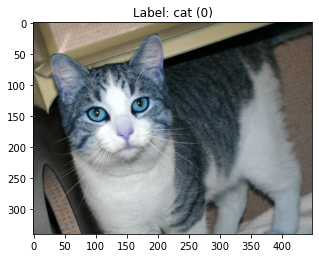

In [115]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(dataset['train']))
sample_img, sample_label = dataset['train'][idx]

key = [k for k, v in classes.items() if v == sample_label][0]
fig = plt.figure(figsize=(5, 5))
img = sample_img.permute(1, 2, 0).numpy()
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Unnormalize image
plt.imshow(img)
plt.title(f"Label: {key} ({sample_label})")
plt.show()

### Dataloaders

In [116]:
BS_train = 32
BS_test = 32

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_test, shuffle=False, num_workers=4),
}

In [117]:
batch_img, batch_img_255, batch_label_255 = next(iter(dataloader['train']))
print(batch_img_255.shape)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/wallabot/anaconda3/envs/cursoPytorch/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/wallabot/anaconda3/envs/cursoPytorch/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/home/wallabot/anaconda3/envs/cursoPytorch/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 175, in default_collate
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/home/wallabot/anaconda3/envs/cursoPytorch/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 175, in <listcomp>
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/home/wallabot/anaconda3/envs/cursoPytorch/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 141, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 288, 352] at entry 0 and [3, 375, 500] at entry 1


## Ejemplo de entrenamiento con backbone descongelada

## Entrenamiento en 2 pasos (cambiar nombre)